In [108]:
import json
import os
import copy
import random 
import numpy as np
from client import *
import matplotlib.pyplot as plt
import datetime

In [100]:
Team_Key = "VPN75t7UGO44XsrQlo9KuKkg8yRrqgSfyh13GITsQnyvLLyvV5" 
Team_Name = "Platypus_Perry"
max_limit = 10 
min_limit = -10
generations = 10
array_len = 11
population_size = 8
chromosome_size = 11
Mutation_Probability = 0.2         # probabilty that it will mutate
Mutation_Difference_Scale = 1000   # adding noice on mutation to actual value ratio
initial_array = [0.0, -1.45799022e-12, -2.28980078e-13,  4.62010753e-11, -1.75214813e-10, -1.83669770e-15,  8.52944060e-16,  2.29423303e-05, -2.04721003e-06, -1.59792834e-08,  9.98214034e-10]
valid_err_best_weights = 0
train_err_best_weights = 0
best_weights_set = []
fitness_best_weights = 0
population = []
best_valid_err_gen = []
best_train_err_gen = []
best_fit_gen = []

In [101]:
def add_noise(arr):
    for id, val in np.ndenumerate(arr):
        Mutation_Probability = 1    
#         Mutation_Probability = np.random.random()
        Mutation_Difference_Scale = np.random.randint(50, 100)
        chance = np.random.random()
        if chance < Mutation_Probability:
            range_var = val/Mutation_Difference_Scale
            if val == 0:
                range_var = np.mean(arr)/(Mutation_Difference_Scale*1000)
            arr[id] = arr[id] + np.random.uniform(-range_var,0)
    return np.clip(arr, min_limit, max_limit)

In [102]:
def add_noise_populate(arr):
    for id, val in np.ndenumerate(arr):
        Mutation_Probability = 1      
#         Mutation_Probability = np.random.random()
        Mutation_Difference_Scale = np.random.randint(10, 20)
        chance = np.random.random()
        if chance < Mutation_Probability:
            range_var = val/Mutation_Difference_Scale
            if val == 0:
                range_var = np.mean(arr)/(Mutation_Difference_Scale*100)
            arr[id] = arr[id] + np.random.uniform(-range_var,0)
    return np.clip(arr, min_limit, max_limit)

In [103]:
def populate(arr):
    arra = []
    for i in range(0,population_size):
        arra.append(arr)
    arra = np.array(arra, dtype=np.double)
    arra = add_noise_populate(arra)
    arra[0] = arr
    return arra

In [104]:
def Roulette_Wheel_Selection(arr ,fitness_sum):
    random_nu = random.uniform(0,fitness_sum)
    for id, val in np.ndenumerate(arr):
        if (val > random_nu):
            return id
    return len(arr) - 1

In [105]:
def get_gen(name_file, i , population):
    j = i
    selected_population = []
    crossovered_population = []
    mutated_population = []
    # global population
    global fitness_best_weights
    global valid_err_best_weights
    global train_err_best_weights

    global best_fit_gen
    global best_train_err_gen
    global best_valid_err_gen
    #finding errors
    fitness = []
    train_error = []
    valid_error = []
    for chromosomes in population:
        train_err, valid_err = get_errors(Team_Key, list(chromosomes))
        # train_err = 1*j
        # valid_err = 1*j
        train_error.append(train_err)
        valid_error.append(valid_err)
        fitness.append(-(train_err + valid_err))

    #updating err values
    best_fit_id = np.argmax(fitness)
    if ( (fitness_best_weights == 0) or (fitness[best_fit_id] > fitness_best_weights)):
        fitness_best_weights = fitness[best_fit_id]
        valid_err_best_weights = valid_error[best_fit_id]
        train_err_best_weights = train_error[best_fit_id]
        best_weights_set[:] = population[best_fit_id]
    
    best_fit_gen.append((-1)*fitness[best_fit_id])
    best_valid_err_gen.append(valid_error[best_fit_id])
    best_train_err_gen.append(train_error[best_fit_id])

    scaled_fitness = (fitness - np.min(fitness)) / np.ptp(fitness) #fitness is scaled from 0 to 1
    partial_sum = []
    sum_fitness = np.sum(scaled_fitness)
    part = 0.0
    for val in scaled_fitness:
        part = part + val
        partial_sum.append(part)

    crossover =[]
    for i in range(0, population_size//2):
        # selection
        selected_f = population[Roulette_Wheel_Selection(partial_sum ,sum_fitness)]
        selected_s = population[Roulette_Wheel_Selection(partial_sum ,sum_fitness)]
        selected_population.append(selected_f)
        selected_population.append(selected_s)

        # crossover 
        crossovered_f = np.copy(selected_f)
        crossovered_s = np.copy(selected_s)
        crossover_point = np.random.randint(4,9)
        crossovered_f[0:crossover_point] = selected_s[0:crossover_point]
        crossovered_s[0:crossover_point] = selected_f[0:crossover_point]
        crossovered_population.append(crossovered_f)
        crossovered_population.append(crossovered_s)
        crossover.append(crossovered_f)
        crossover.append(crossovered_s)
    
    #mutation
    crossover = np.array(crossover, dtype=np.double)
    population = add_noise(crossover)
    mutated_population = population

    #creating generation files
    file_name = str(name_file) + "/" + "generations_" + str(j+1) + ".txt"
    
    selected_population = np.array(selected_population)
    crossovered_population = np.array(crossovered_population)
    mutated_population = np.array(mutated_population)
    with open(file_name, 'w') as write_file:
        json.dump(selected_population.tolist(), write_file)
        write_file.write('\n' + '\n')
        json.dump(crossovered_population.tolist(), write_file)
        write_file.write('\n' + '\n')
        json.dump(mutated_population.tolist(), write_file)
    return population


In [106]:
name_file = "generations44"
if (os.path.isdir(name_file) != 1):
    os.mkdir(name_file)
population = populate(initial_array)
population = np.array(population , dtype=np.double)

for i in range(0,generations):
    population = get_gen(name_file, i , population)
    
print("best values >>>>>>>>",name_file,datetime.datetime.now(),file=open("tt.txt" , "a"))
print(fitness_best_weights,"\n", valid_err_best_weights,"\n", train_err_best_weights,"\n", best_weights_set,file=open("tt.txt" , "a"))
print("=================================================================================\n\n\n\n",file=open("tt.txt" , "a"))


In [133]:
vvtt = [2.0374996418572782e-11, -1.4526799917507029e-12, -2.2885115960632773e-13, 4.622064121435299e-11, -1.7729884949205562e-10, -1.828665836610777e-15, 8.548200456219395e-16, 2.3126531087115558e-05, -2.034699406397571e-06, -1.6180516299162877e-08, 9.852418599341256e-10]

submit(Team_Key,list(vvtt))

'successfully submitted'

[3.44927285e+11 3.18259461e+11 3.57051476e+11 3.33954886e+11
 3.23816326e+11 3.09936528e+11 3.19971027e+11 3.33617863e+11
 3.35462802e+11 3.32507299e+11]
[3.19917815e+11 2.72901562e+11 3.34951908e+11 3.02370507e+11
 2.84580750e+11 2.48367606e+11 2.78546937e+11 2.92325139e+11
 2.90870724e+11 3.03141079e+11]
[2.50094692e+10 4.53578995e+10 2.20995686e+10 3.15843792e+10
 3.92355761e+10 6.15689227e+10 4.14240896e+10 4.12927238e+10
 4.45920776e+10 2.93662200e+10]


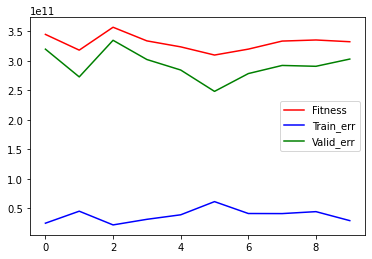

In [107]:
best_fit_gen = np.array(best_fit_gen, dtype = np.double)
best_train_err_gen = np.array(best_train_err_gen, dtype = np.double)
best_valid_err_gen = np.array(best_valid_err_gen, dtype = np.double)
print(best_fit_gen)
print(best_valid_err_gen)
print(best_train_err_gen)
plt.plot(best_fit_gen , color = "red")
plt.plot(best_train_err_gen, color ="blue" )
plt.plot(best_valid_err_gen , color = "green")
plt.legend(["Fitness", "Train_err", "Valid_err"])
plt.show()